## Causal Learning notebook for Break-Cancer Diagnosis

### Importing necessary packages, and libraries

In [1]:
import logging
import logging.handlers
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from causalgraphicalmodels import CausalGraphicalModel
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas

import os
import sys

sys.path.append(os.path.abspath(os.path.join('../scripts')))
from project_config import Config
from FileHandler import FileHandler
from log import logger
from data_processor import data_processor
from plot import Plot

## Creating Script Class Objects

In [2]:
sm = StructureModel()
file = FileHandler()
log = logger('eda_logs')
file_config = Config()
data_processor = data_processor()
plot = Plot()

## Loading the Dataset

In [3]:
# print(Config.Data_path)
df = file.csv_file_read("processed_data")
# print("Dataset columns are: ", df.columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

## Discovering the Relationship/Correlations between features 
### Using Features with With higher collerations (>=0.5)

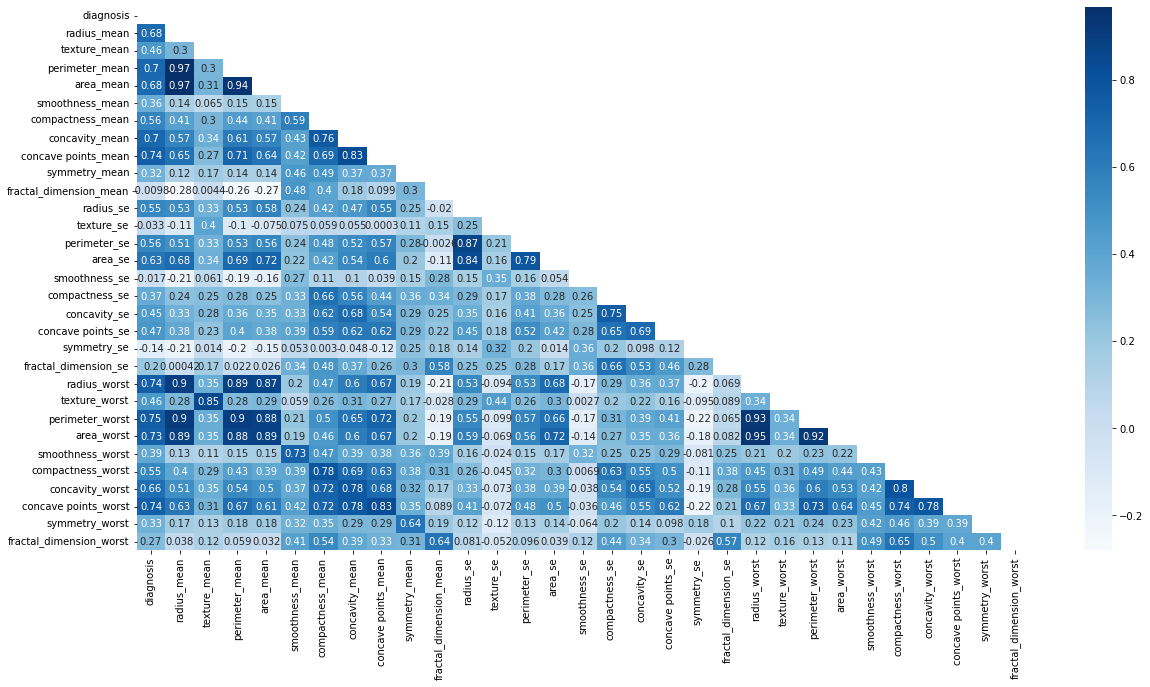

In [4]:
# Finding features with Higher correlations to diagnosis
plot.heat(df, "Blues", (20,10))

### From the Diagram, we can get an intuitions about the corrections values between the features

## Drawing the Causal graph

In [5]:
# Removing the less important features (with less correlation)
columns_list = ['smoothness_mean', 'smoothness_mean', 'smoothness_mean','texture_se', 'smoothness_se', 'symmetry_se']
df = data_processor.drop_columns(df, columns_list)
columnns = df.columns

## Scalling the dataset

In [6]:
df = data_processor.data_scaler(df)
df.columns = columnns

In [7]:
df.sample(3)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
338,0.0,0.225844,0.448394,0.224350,0.143667,0.284598,0.103889,0.141434,0.667739,0.512083,...,0.183003,0.611134,0.178722,0.109003,0.691476,0.210610,0.154919,0.275849,0.533735,0.337184
92,0.0,0.462801,0.289564,0.445545,0.350537,0.164642,0.134919,0.210996,0.262269,0.123514,...,0.477620,0.425979,0.448173,0.353877,0.294801,0.180019,0.198238,0.424873,0.185542,0.109585
133,0.0,0.642358,0.241972,0.633337,0.530872,0.397422,0.295201,0.472749,0.608206,0.278865,...,0.542210,0.298144,0.529373,0.404430,0.512171,0.312641,0.250954,0.583192,0.465060,0.244614


## Dividing the Features in Mean, SE and Worst, and study their causal relationships

In [8]:
mean_columns = df.iloc[:, 0:11]
se_columns = df.iloc[:, 11: 21]
worst_columns = df.iloc[:,21:31]
se_columns["diagnosis"] = df.iloc[:, 0:1]
worst_columns["diagnosis"] = df.iloc[:, 0:1]

In [9]:
sm = from_pandas(mean_columns)

In [10]:
sm_se = from_pandas(se_columns)
sm_worst = from_pandas(worst_columns)

### Edge Pruning
Apply thresholding to the weaker edges of the graph. Thresholding can be applied either by specifying the value for the parameter w_threshold in from_pandas, or we can remove the edges by calling the structure model function, remove_edges_below_threshold.

### 1.0 Mean Valued Features

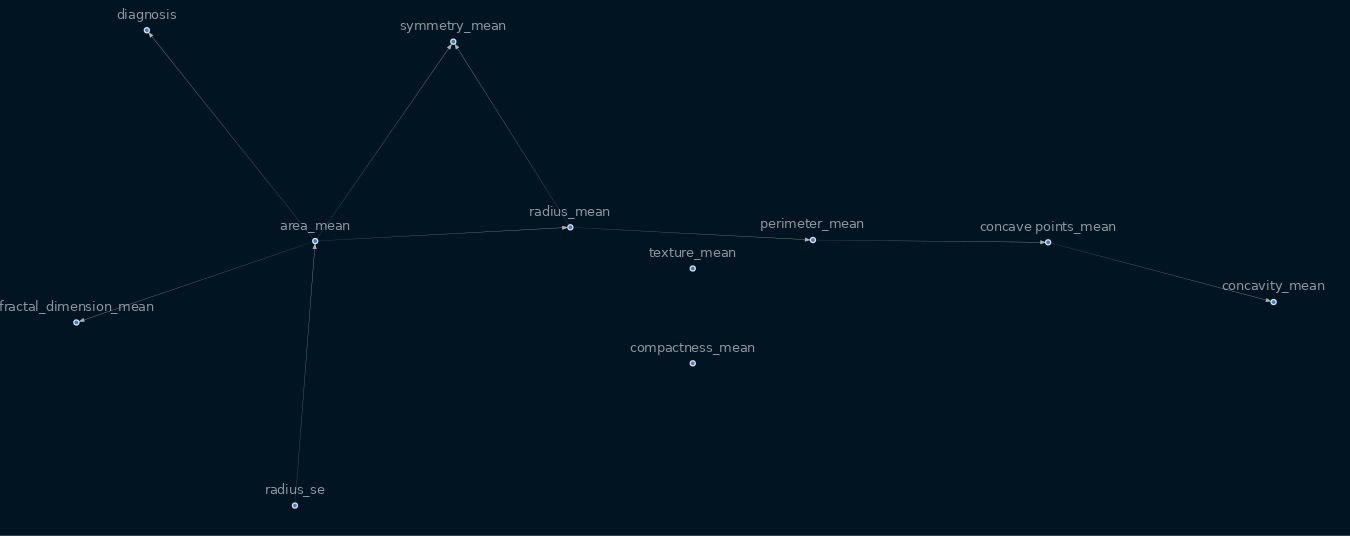

In [13]:
import causalnex
from IPython.display import Image
from causalnex.plots import plot_structure,NODE_STYLE,EDGE_STYLE

sm.remove_edges_below_threshold(0.8)

viz = plot_structure(
    sm,
    graph_attributes={"scale": "2.5",'size':'4.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))



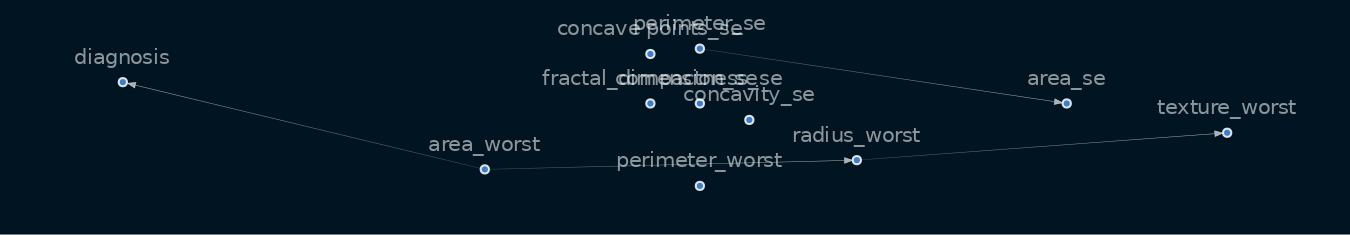

In [19]:
sm_se.remove_edges_below_threshold(0.8)

viz = plot_structure(
    sm_se,
    graph_attributes={"scale": "2.5",'size':'4.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

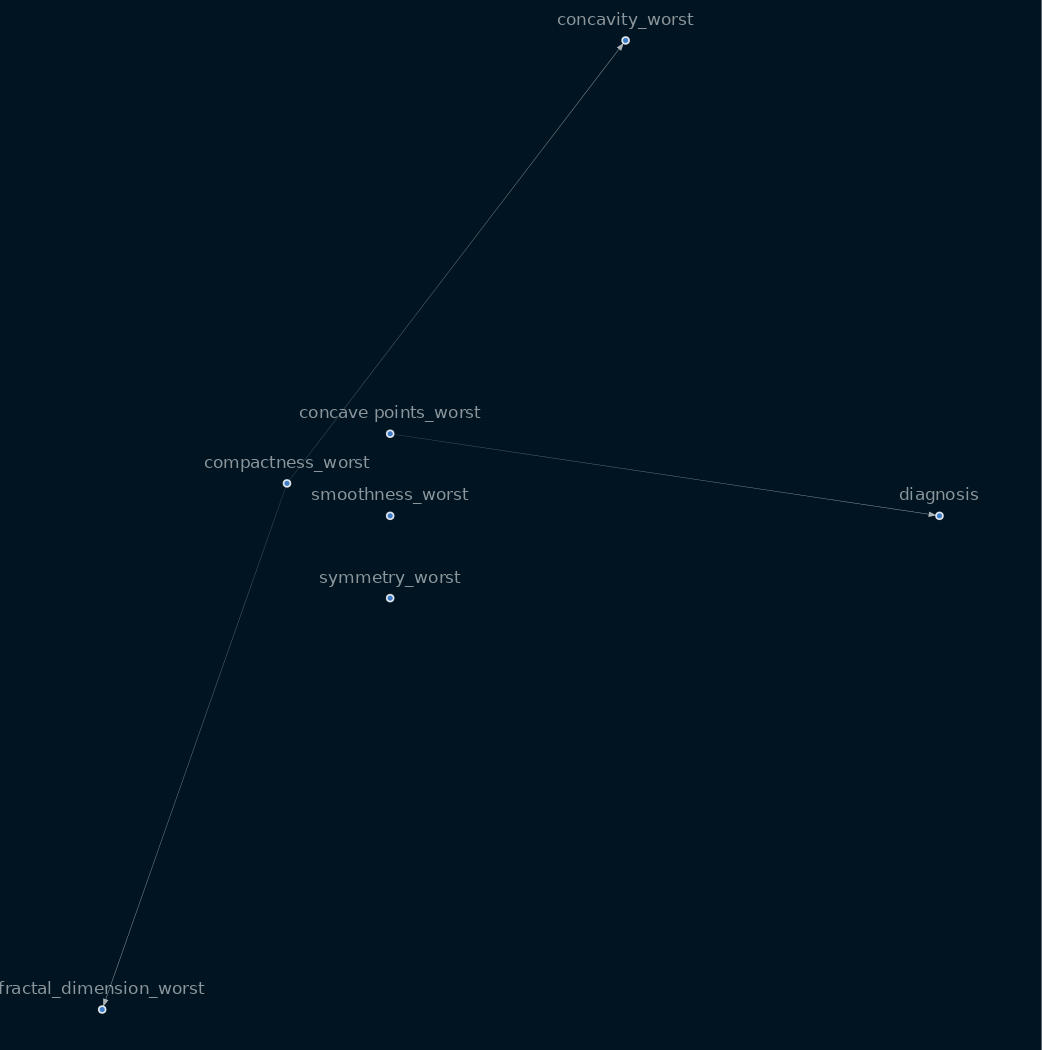

In [23]:
sm_worst.remove_edges_below_threshold(0.8)

viz = plot_structure(
    sm_worst,
    graph_attributes={"scale": "4.5",'size':'3.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [ ]:
sm = from_pandas(df)

2.0 SE Valued Features

In [ ]:
sm_se.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "2.5",'size':'2.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

## Model Building Using All Features Vs Features Obtained through Causal Inference

## 1.0 Using All features

In [19]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score

# Splitting dependent and independent columns
x = df.drop(columns = 'diagnosis')
y = df['diagnosis']

In [20]:
# Split 80% train and 20% test
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=10)

### Testing Using Logistic Regression

In [21]:
model_logistic = LogisticRegression()
model_logistic.fit(x_train, y_train)
print('Logistic regression accuracy: {:.4f}'.format(accuracy_score(y_test, model_logistic.predict(x_test))))

Logistic regression accuracy: 0.9737


### Testing Using Random Forest Classfier

In [22]:
model_randomforest = RandomForestClassifier()
model_randomforest.fit(x_train, y_train)
print('Random Forest accuracy: {:.4f}'.format(accuracy_score(y_test, model_randomforest.predict(x_test))))

Random Forest accuracy: 0.9561


## 2.0 Using delective Features from Causal Inference

### Preparing dataset, droping all columns that have little contributions on Diagnosis

In [ ]:
columns_list = ['smoothness_mean', 'smoothness_mean', 'smoothness_mean','texture_se', 'smoothness_se', 'symmetry_se']
df = data_processor.drop_columns(df, columns_list)

In [ ]:
# Splitting dependent and independent columns
x = df.drop(columns = 'diagnosis')
y = df['diagnosis']

In [ ]:
# Split 80% train and 20% test
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=10)

### Testing Using Logistic Regression

In [ ]:
model_logistic = LogisticRegression()
model_logistic.fit(x_train, y_train)
print('Logistic regression accuracy: {:.4f}'.format(accuracy_score(y_test, model_logistic.predict(x_test))))

### Testing Using Random Forest Classfier

In [ ]:
model_randomforest = RandomForestClassifier()
model_randomforest.fit(x_train, y_train)
print('Random Forest accuracy: {:.4f}'.format(accuracy_score(y_test, model_randomforest.predict(x_test))))